# Sperm Detection using YOLOv7

## Part 1 - Data processing

-------------------------------------

[**VISEM**](https://datasets.simula.no/visem/) is a multimodal video dataset of human spermatozoa. The dataset contains over 35 GB of videos, with each video lasting between two to seven minutes. The resolution of the videos is $640 \times 480$, and the frame-rate is 50 FPS. There are 3 class labels: **sperm**, **cluster** and **small/pinhead**. For example:

<div style="display: flex; flex-direction: column; align-items: center;">
<img src='https://production-media.paperswithcode.com/datasets/ad567975-6c2b-4d04-8773-b059a3f858d6.png'/>
<p>Red: sperm, Green: cluster, Blue: small/pinhead</p>
</div>

In this tutorial, we will use a subset of the original version. Let's download it by the following links:
- Train: https://drive.google.com/file/d/1kCyVy9pQJXEEkfANbSDuLdQoI1pyKjsN/view?usp=share_link
- Val: https://drive.google.com/file/d/1x1ldk9pFPusqLBEEi1n1lMQnozzrDtKC/view?usp=share_link



Assumed that you put them in the folder `visem-raw`, so we will have the following structure:

    visem-raw/
        |- Train/
            |- 13/
                |- images/
                |- labels/
                |- ...
            |- ...
        |- Val
            |- 11/
                |- images/
                |- labels/
                |- ...
            |- ...
    
The format of current annotations for objects in data is currently **YOLO format**, which means it has 5 value determining the object: `class`, `x_center`, `y_center`, `width`, `height`, where `x_center`, `y_center`, `width`, `height` are in [0, 1]. For example:

In [2]:
ex_img_path = './visem-raw/Val/11/images/11_frame_1000.jpg'
ex_ann_path = './visem-raw/Val/11/labels/11_frame_1000.txt'
with open(ex_ann_path, 'r') as f:
    print(f.readline())

0 0.26484375 0.4354166666666667 0.0265625 0.0375



To have a better understanding, we will visualize the annotations of some images:

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

colors = {
    0: (0, 0, 255),
    1: (0, 255, 0),
    2: (255, 0, 0),
}
classes = {
    0: 'sperm',
    1: 'cluster',
    2: 'small/pinhead'
}

def draw_box(img_path, label_path):
    with open(label_path, 'r') as f:
        label = f.read()
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    for line in label.split('\n'):
        box = [np.float64(x) for x in line.split()]
        if len(box) < 5:
            continue
        class_id = int(box[0])
        x_c = (width * box[1])
        y_c = (height * box[2])
        w = (width * box[3])
        h = (height * box[4])
        x_min, y_min, x_max, y_max = int(x_c - w/2), int(y_c - h/2), int(x_c + w/2), int(y_c + h/2)
        cv2.rectangle(img, pt1=(x_min, y_min), pt2=(x_max, y_max),
                      color=colors[class_id], thickness=1)
        img = cv2.putText(img, text=classes[class_id], org=(x_min - 5, y_min - 5),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                          color=colors[class_id], thickness=1, lineType=cv2.LINE_AA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 8))
    plt.imshow(img)
    plt.axis('off')

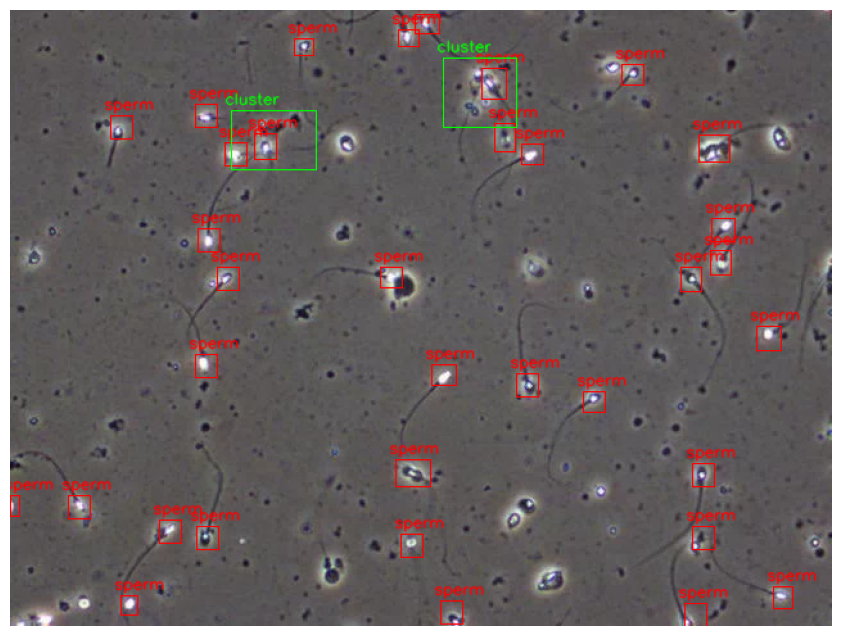

In [5]:
ex_img_path = './visem-raw/Val/11/images/11_frame_1000.jpg'
ex_ann_path = './visem-raw/Val/11/labels/11_frame_1000.txt'
draw_box(ex_img_path, ex_ann_path)

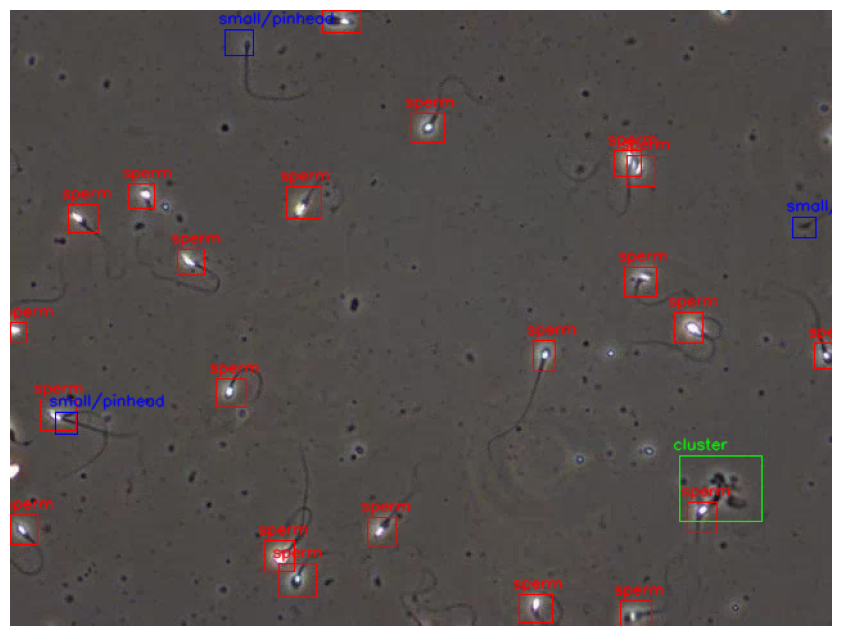

In [14]:
ex_img_path = './visem-raw/Val/12/images/12_frame_800.jpg'
ex_ann_path = './visem-raw/Val/12/labels/12_frame_800.txt'
draw_box(ex_img_path, ex_ann_path)

Let's move images and labels to the right folder structure:

    |- visem-yolo/
        |- train/
            |- images/
                |- *.jpg
            |- labels/
                |- *.txt
        |- val/
            |- images/
                |- *.jpg
            |- labels/
                |- *.txt

In [28]:
import os
import shutil
from tqdm import tqdm

def move_files(root='./visem-raw/Train', imgs_dst_folder='', labels_dst_folder=''):
    for video in tqdm(os.listdir(root)):
        video_path = os.path.join(root, video)

        img_folder = os.path.join(video_path, 'images')
        label_folder = os.path.join(video_path, 'labels')
        
        if not os.path.exists(imgs_dst_folder):
            os.mkdir(imgs_dst_folder)
        if not os.path.exists(labels_dst_folder):
            os.mkdir(labels_dst_folder)

        for img_name in os.listdir(img_folder):
            label_name = img_name.split('.')[0] + '.txt'
            if not os.path.exists(os.path.join(label_folder, label_name)):
                continue

            img_path = os.path.join(img_folder, img_name)
            label_path = os.path.join(label_folder, label_name)
            shutil.move(img_path, os.path.join(imgs_dst_folder, img_name))
            shutil.move(label_path, os.path.join(labels_dst_folder, label_name))

In [27]:
!mkdir ./visem-yolo
!mkdir ./visem-yolo/train
!mkdir ./visem-yolo/val

In [29]:
move_files(root='./visem-raw/Val/', imgs_dst_folder='./visem-yolo/val/images', labels_dst_folder='./visem-yolo/val/labels')

100%|██████████| 4/4 [00:00<00:00,  8.85it/s]


In [30]:
move_files(root='./visem-raw/Train/', imgs_dst_folder='./visem-yolo/train/images', labels_dst_folder='./visem-yolo/train/labels')

100%|██████████| 16/16 [00:01<00:00, 14.40it/s]


Next, we need a `yaml` file to describe some information about this dataset for later use.

In [19]:
content = '''
# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: ./visem-yolo/train/images/
val: ./visem-yolo/val/images/

# number of classes
nc: 3

# class names
names: [ 'sperm', 'cluster', 'small/pinhead' ]
'''

with open('visem.yaml', 'w') as f:
    f.write(content)